# Trade Data Background and Insights

https://ec.europa.eu/eurostat/web/international-trade-in-goods

International trade in goods statistics (ITGS) published by Eurostat measure the value and quantity of goods traded between the EU Member States and their trade partners. The data contain the import of three goods. 

Self-explanatory descriptions (https://ec.europa.eu/eurostat/ramon/nomenclatures/index.cfm?TargetUrl=LST_NOM_DTL&StrNom=CN_2022&StrLanguageCode=EN&IntPcKey=&StrLayoutCode=HIERARCHIC&IntCurrentPage=1):
- Sunflower oil
    - index=0 15121191: Crude sunflower-seed oil (excl. for technical or industrial uses) 
    - index=1 15121990: Sunflower-seed or safflower oil and their fractions, whether or not refined, but not chemically modified (excl. for technical or industrial uses and crude)

- Maize corn:
    - index=0 10059000: Maize (excl. seed for sowing)
    
- Wheat:
    - index=0 10011900: Durum wheat (excl. seed for sowing)
    - index=1 10019900: Wheat and meslin (excl. seed for sowing, and durum wheat)
    - index=2 10081000: Buckwheat

The data contains among others, the following four fields for the case:
- TIME_PERIOD: the month in which the goods were imported
- declarant: The country to where the goods are imported (3 = The Netherlands)
- partner: The country where the goods originate from.
- indicators: Indicates whether the value is the Quantity or the Value measure
- OBS_Value: the field that indicates the actual value.

#### Create Dataframe for each good 

In [85]:
import pandas as pd
import datetime

def process_csv(filepath, product_index):
    trade_data = pd.read_csv(filepath)

    trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
    trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
    trade_data = trade_data.drop_duplicates()
    #trade_data = trade_data.dropna()

    products = trade_data["product"].drop_duplicates().to_list()
    product_filter = products[product_index]

    partner_countries = pd.read_csv("trade_data/partners.csv", sep = ";")

    trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

    trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                                  columns='indicators', 
                                  values=['OBS_VALUE'])

    trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
    trade_data_pivot = trade_data_pivot.reset_index()
    trade_data_pivot = trade_data_pivot.dropna()

    df = trade_data_pivot
    df_product_filtered = df[df['product'] == product_filter]
    
    return df_product_filtered

#Declare DataFrames for all good/productcode combinations
df_sunflower_oil_0 = process_csv("trade_data/sunflower_oil.csv", 0)
df_sunflower_oil_1 = process_csv("trade_data/sunflower_oil.csv", 1)
df_maize_corn_0 = process_csv("trade_data/maize_corn.csv", 0)
df_wheat_0 = process_csv("trade_data/wheat.csv", 0)
df_wheat_1 = process_csv("trade_data/wheat.csv", 1)
df_wheat_2 = process_csv("trade_data/wheat.csv", 2)




## Top 10 partner countries for each good and every product (average (!!!) import quantity)

In [86]:
def get_means_list(df):
    # Select the columns to use
    df = df[["PARTNER_Labels", "OBS_VALUE_QUANTITY_TON"]]

    # Group the data by the unique values in "column1"
    grouped_df = df.groupby("PARTNER_Labels")

    # Take the mean of "column2" for each group
    means = grouped_df["OBS_VALUE_QUANTITY_TON"].mean()

    # Sort the means in descending order
    sorted_means = means.sort_values(ascending=False)

    # Save the means in a list
    means_list = list(zip(sorted_means.index, sorted_means))

    return means_list[:10]

# Call the function and store the result in a variable
means_list_sunflower_oil_0 = get_means_list(df_sunflower_oil_0)
means_list_sunflower_oil_1 = get_means_list(df_sunflower_oil_1)
means_list_maize_corn_0 = get_means_list(df_maize_corn_0)
means_list_wheat_0 = get_means_list(df_wheat_0)
means_list_wheat_1 = get_means_list(df_wheat_1)
means_list_wheat_2 = get_means_list(df_wheat_2)

dfs_and_means = [
    (df_sunflower_oil_0, means_list_sunflower_oil_0),
    (df_sunflower_oil_1, means_list_sunflower_oil_1),
    (df_maize_corn_0, means_list_maize_corn_0),
    (df_wheat_0, means_list_wheat_0),
    (df_wheat_1, means_list_wheat_1),
    (df_wheat_2, means_list_wheat_2),
]

# Create an empty list to store the rows of the final DataFrame
rows = []

# Iterate over the list of tuples and create a row for each dataframe
for df, means_list in dfs_and_means:
    # Create a dictionary with the data for the current row
    row = {
        '#1': means_list[0],
        '#2': means_list[1],
        '#3': means_list[2],
        '#4': means_list[3],
        '#5': means_list[4],
        '#6': means_list[5],
        '#7': means_list[6],
        '#8': means_list[7],
        '#9': means_list[8],
        '#10': means_list[9],
        # Add more columns here if needed
    }
    # Append the row to the list of rows
    rows.append(row)

# Create a DataFrame from the rows
df_means = pd.DataFrame(rows)

# Display the DataFrame (transpose)
df_top10 = df_means.T
df_top10.columns=['Crude sunflower-seed oil', 'Sunflower-seed or safflower oil', ' Maize', 'Durum wheat', 'Wheat and meslin', 'Buckwheat']
df_top10

Crude sunflower-seed oil       Sunflower-seed or safflower oil  \
#1    (Ukraine, 20906.436842105264)          (Moldova, 4342.733333333334)   
#2    (Argentina, 8412.71794871795)         (Ukraine, 2922.2754098360656)   
#3            (Philippines, 6975.2)         (Belgium, 2769.3602803738318)   
#4     (Hungary, 6268.249606299212)         (Germany, 2332.8271028037384)   
#5    (Bolivia, 3119.2599999999998)           (France, 985.1616822429907)   
#6    (Moldova, 2612.4285714285716)            (Spain, 330.0284615384615)   
#7     (Russia, 2543.2250000000004)          (Romania, 232.9738095238095)   
#8      (France, 2023.478971962617)  (United Kingdom, 212.25898876404494)   
#9   (Bulgaria, 1063.9737373737373)         (Hungary, 168.11353383458646)   
#10                 (Norway, 973.4)         (Austria, 146.18727272727273)   

                             Maize                      Durum wheat  \
#1   (Ukraine, 149147.13092105262)     (Germany, 7004.943076923077)   
#2     (France, 97283.62523364487)         (United States, 5456.25)   
#3     (Brazil, 54848.87810218978)      (Canada, 5141.782978723404)   
#4    (Germany, 33330.11915887851)     (Belgium, 4754.033076923078)   
#5   (Romania, 31279.176229508197)                 (Russia, 4400.0)   
#6   (Hungary, 18668.968691588783)     (France, 4113.1411290322585)   
#7     (Russia, 16452.49662921348)                (Ukraine, 3157.5)   
#8    (Serbia, 15256.206976744186)  (Kazakhstan, 2256.733333333333)   
#9    (Canada, 15220.123529411765)               (Moldova, 338.875)   
#10  (Belgium, 14056.164018691588)       (Spain, 287.8175824175824)   

                         Wheat and meslin                         Buckwheat  
#1           (France, 151817.47999999998)       (China, 255.92868852459017)  
#2           (Germany, 87141.07384615384)      (Poland, 183.73541666666665)  
#3           (Belgium, 32241.18230769231)   (Lithuania, 159.36666666666667)  
#4           (Serbia, 22012.099999999995)  (New Zealand, 64.27777777777777)  
#5   (United Kingdom, 15085.814728682171)                  (Ukraine, 38.89)  
#6          (Romania, 13922.781651376146)      (Russia, 37.334782608695654)  
#7           (Latvia, 7272.2043478260875)     (Belarus, 21.866666666666664)  
#8                    (Russia, 7094.7475)                    (India, 19.16)  
#9           (Ukraine, 6505.112087912087)     (Czechia, 15.504651162790699)  
#10          (Denmark, 5902.565853658536)     (Germany, 14.912637362637362)

## Graphical Inspection

In [87]:
date_filter = datetime.date(year=2010,month=1,day=1)

### Ukraine's exports over time

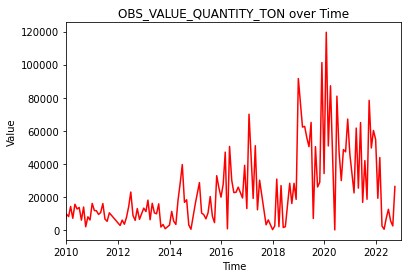

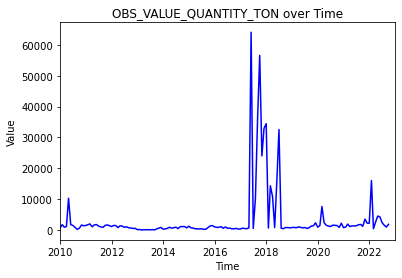

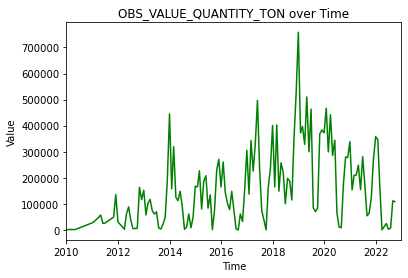

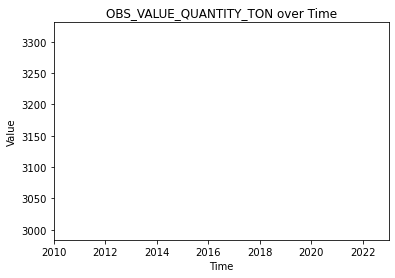

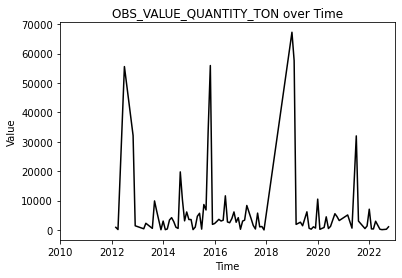

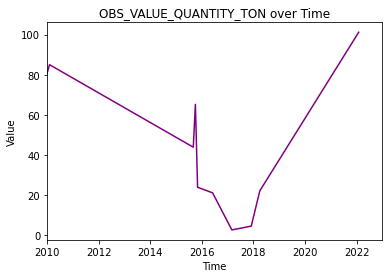

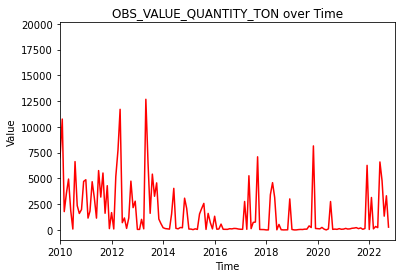

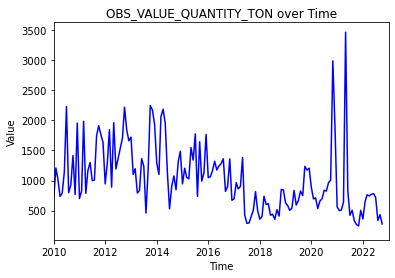

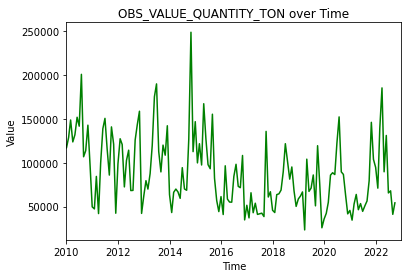

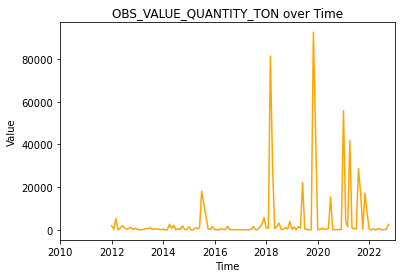

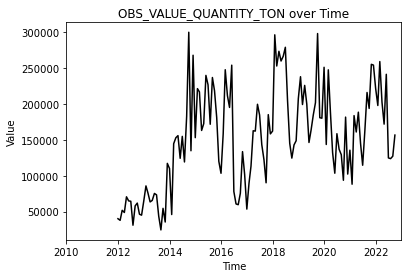

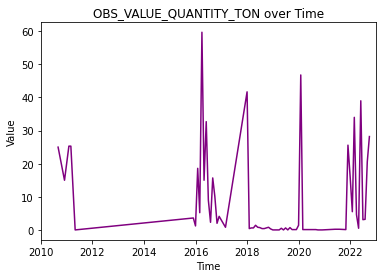

In [90]:
import matplotlib.pyplot as plt

# List of DataFrames
dataframes = [df_sunflower_oil_0, df_sunflower_oil_1, df_maize_corn_0, df_wheat_0, df_wheat_1, df_wheat_2]

# List of values for the 'Type' column
values = ['Ukraine', 'France']
#values = ['Ukraine', 'Germany', 'France', 'China', 'Moldova']

# List of colors
colors = ['red', 'blue', 'green', 'orange', 'black', 'purple']

#red: Crude sunflower-seed oil
#blue: Sunflower-seed or safflower oil
#green: Maize
#orange: Durum wheat
#black: Wheat and meslin
#purple: Buckwheat


for value in values:
    # Loop through each DataFrame and value
    for df, color in zip(dataframes, colors):
        # Select the rows where the value in the 'Type' column is 'Specific Value'
        df_specific_value = df[(df['PARTNER_Labels'] == value)]

        # Make a line plot with time on the x-axis and the 'Value' column on the y-axis
        plt.plot(df_specific_value['TIME_PERIOD'], df_specific_value['OBS_VALUE_QUANTITY_TON'], color=color)

        # Add a title and label the axes
        plt.title('OBS_VALUE_QUANTITY_TON over Time')
        plt.xlabel('Time')
        plt.ylabel('Value')

        # Set the x-axis limits
        plt.xlim(date_filter, pd.Timestamp('2022-12-30'))

        # Display the plot
        plt.show()

### BELOW IS CODE JUNK

In [8]:
import pandas as pd
import datetime

trade_data = pd.read_csv("trade_data/wheat.csv")

trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
trade_data = trade_data.drop_duplicates()
#trade_data = trade_data.dropna()

products = trade_data["product"].drop_duplicates().to_list()
product_filter = products[1]

partner_countries = pd.read_csv("trade_data/partners.csv", sep = ";")

trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

df = trade_data_pivot


KeyError: 'PARTNER_Labels'

In [10]:
import pandas as pd
import datetime

trade_data = pd.read_csv("trade_data/maize_corn.csv")

trade_data["TIME_PERIOD"] = pd.to_datetime(trade_data["TIME_PERIOD"], format = '%Y-%m').dt.date
trade_data = trade_data.rename(columns={"partner": "PARTNER_codes", "declarant": "DECLARANT_codes"})
trade_data = trade_data.drop_duplicates()
#trade_data = trade_data.dropna()


KeyError: 'PARTNER_Labels'

In [7]:
products = trade_data["product"].drop_duplicates().to_list()
product_filter = products[0]

trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

print(products)
print(product_filter)

[100119, 100199, 100810]
100119


#### We've also included a file with the labels for all the partner countries:

In [146]:
partner_countries = pd.read_csv("trade_data/partners.csv", sep = ";")
print(partner_countries.head(7))

   PARTNER_codes  PARTNER_Labels
0              1          France
1              3     Netherlands
2              4         Germany
3              5           Italy
4              6  United Kingdom
5              7         Ireland
6              8         Denmark


#### View of the data:

In [147]:
trade_data = pd.merge(trade_data, partner_countries, on = ['PARTNER_codes'], how = 'inner')

print(trade_data.head(5))

               DATAFLOW        LAST UPDATE freq  DECLARANT_codes  \
0  ESTAT:DS-057380(1.0)  03/01/23 13:41:00    M                3   
1  ESTAT:DS-057380(1.0)  03/01/23 13:41:00    M                3   
2  ESTAT:DS-057380(1.0)  03/01/23 13:41:00    M                3   
3  ESTAT:DS-057380(1.0)  03/01/23 13:41:00    M                3   
4  ESTAT:DS-057380(1.0)  03/01/23 13:41:00    M                3   

   PARTNER_codes  product  flow  stat_regime    indicators TIME_PERIOD  \
0              1   100119     1            1  QUANTITY_TON  2012-01-01   
1              1   100119     1            1  QUANTITY_TON  2012-02-01   
2              1   100119     1            1  QUANTITY_TON  2012-03-01   
3              1   100119     1            1  QUANTITY_TON  2012-04-01   
4              1   100119     1            1  QUANTITY_TON  2012-05-01   

   OBS_VALUE  OBS_FLAG PARTNER_Labels_x PARTNER_Labels_y  
0     1973.4       NaN           France           France  
1      283.6       NaN      

In [9]:

trade_data_pivot = trade_data.pivot(index=['PARTNER_Labels', 'TIME_PERIOD', 'product'], 
                              columns='indicators', 
                              values=['OBS_VALUE'])

trade_data_pivot.columns = trade_data_pivot.columns.map('_'.join)
trade_data_pivot = trade_data_pivot.reset_index()
trade_data_pivot = trade_data_pivot.dropna()

df = trade_data_pivot

KeyError: 'PARTNER_Labels'

In [149]:
# Get a list of the unique values in the 'PARTNER_Labels' column
categories = df['PARTNER_Labels'].unique()

# Create an empty dictionary to store the results
results = {}

# Iterate over the categories
for category in categories:
  # Select rows where the value in the 'PARTNER_Labels' column is equal to the current category
  df_filtered = df[df['PARTNER_Labels'] == category]

  # Compute the mean of the 'Column2' column for the filtered data frame
  mean_value = df_filtered['OBS_VALUE_VALUE_1000EURO'].mean()

  # Add the mean value to the results dictionary
  results[category] = mean_value

# Sort the results in descending order
sorted_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}

# Print the sorted results
print(sorted_results)

{'France': 12084.959689440999, 'Germany': 5778.488257918548, 'Serbia': 4130.376666666667, 'Belgium': 2157.7988988764046, 'Ukraine': 1327.214803921569, 'United Kingdom': 1298.970178571429, 'Canada': 1157.4081967213117, 'Russia': 1105.6782812500003, 'Romania': 1031.9397003745337, 'Kazakhstan': 565.007, 'Denmark': 466.70218978102105, 'Latvia': 449.65196078431376, 'United States': 399.32333333333355, 'Sweden': 393.77688976377897, 'Lithuania': 364.0780519480517, 'Türkiye': 340.64074999999997, 'Bulgaria': 297.28088495575196, 'Moldova': 290.1665217391305, 'Estonia': 183.52133047210296, 'Poland': 159.80162371134028, 'Finland': 133.64056224899593, 'Hungary': 127.20515873015859, 'Czechia': 123.33176470588239, 'Argentina': 111.63000000000001, 'China': 94.66910569105687, 'Austria': 64.27756000000002, 'Spain': 46.973712121212124, 'Luxembourg': 40.99930921052638, 'New Zealand': 37.013400000000004, 'Italy': 36.51317829457367, 'Morocco': 30.89, 'Slovakia': 21.92301158301163, 'Croatia': 14.823756613756

In [150]:
print(trade_data_pivot.head(5000))

                 PARTNER_Labels TIME_PERIOD  product  OBS_VALUE_QUANTITY_TON  \
0                     Argentina  2017-02-01   100199                   369.6   
1                     Argentina  2019-03-01   100199                   432.9   
2                     Australia  2022-10-01   100199                     0.0   
3                       Austria  2010-03-01   100810                    25.7   
4                       Austria  2013-04-01   100199                  1294.8   
5                       Austria  2013-06-01   100199                  1048.6   
6                       Austria  2013-07-01   100199                  1149.0   
7                       Austria  2014-06-01   100199                     0.8   
8                       Austria  2014-07-01   100199                  1000.0   
9                       Austria  2014-11-01   100199                  2092.0   
10                      Austria  2014-12-01   100199                   997.7   
11                      Austria  2015-02

# Graphical Inspection Data

In [153]:
date_filter = datetime.date(year=2018,month=1,day=1)
date_filter

datetime.date(2018, 1, 1)

## Ukraine

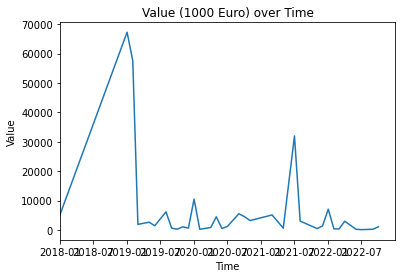

PARTNER_Labels TIME_PERIOD  product  OBS_VALUE_QUANTITY_TON  \
7415        Ukraine  2012-03-01   100199                   879.4   
7416        Ukraine  2012-04-01   100199                   130.4   
7417        Ukraine  2012-07-01   100199                 55593.0   
7418        Ukraine  2012-11-01   100199                 32121.7   
7419        Ukraine  2012-12-01   100199                  1408.0   
7420        Ukraine  2013-04-01   100199                   386.8   
7421        Ukraine  2013-05-01   100199                  2261.3   
7422        Ukraine  2013-08-01   100199                   525.0   
7423        Ukraine  2013-09-01   100199                  9868.3   
7424        Ukraine  2013-10-01   100199                  6482.6   
7425        Ukraine  2013-12-01   100199                    60.7   
7426        Ukraine  2014-01-01   100199                  3008.0   
7427        Ukraine  2014-02-01   100199                    86.0   
7428        Ukraine  2014-03-01   100199                   322.5   
7429        Ukraine  2014-04-01   100199                  3374.6   
7430        Ukraine  2014-05-01   100199                  4173.9   
7431        Ukraine  2014-06-01   100199                  2786.4   
7432        Ukraine  2014-07-01   100199                   925.9   
7433        Ukraine  2014-08-01   100199                   511.1   
7434        Ukraine  2014-09-01   100199                 19749.7   
7435        Ukraine  2014-10-01   100199                 10361.5   
7436        Ukraine  2014-11-01   100199                  3086.2   
7437        Ukraine  2014-12-01   100199                  6115.4   
7438        Ukraine  2015-01-01   100199                  3538.3   
7439        Ukraine  2015-02-01   100199                  3529.0   
7440        Ukraine  2015-03-01   100199                   110.0   
7441        Ukraine  2015-04-01   100199                   954.5   
7443        Ukraine  2015-05-01   100199                  4636.4   
7444        Ukraine  2015-06-01   100199                  5662.9   
7445        Ukraine  2015-07-01   100199                   268.6   
7446        Ukraine  2015-08-01   100199                  8647.1   
7447        Ukraine  2015-09-01   100199                  6789.2   
7449        Ukraine  2015-10-01   100199                 33529.2   
7451        Ukraine  2015-11-01   100199                 55951.3   
7453        Ukraine  2015-12-01   100199                  1887.4   
7454        Ukraine  2016-01-01   100199                  2183.9   
7455        Ukraine  2016-02-01   100199                  2893.4   
7456        Ukraine  2016-03-01   100199                  3602.1   
7457        Ukraine  2016-04-01   100199                  3025.9   
7458        Ukraine  2016-05-01   100199                  3311.4   
7459        Ukraine  2016-06-01   100199                 11609.5   
7461        Ukraine  2016-07-01   100199                  2712.8   
7462        Ukraine  2016-08-01   100199                  2448.3   
7463        Ukraine  2016-09-01   100199                  3857.3   
7464        Ukraine  2016-10-01   100199                  6122.9   
7465        Ukraine  2016-11-01   100199                  2610.7   
7466        Ukraine  2016-12-01   100199                  4177.5   
7467        Ukraine  2017-01-01   100199                   220.0   
7468        Ukraine  2017-02-01   100199                  3013.7   
7469        Ukraine  2017-03-01   100199                  3325.0   
7471        Ukraine  2017-04-01   100199                  8316.3   
7472        Ukraine  2017-06-01   100199                  3850.4   
7473        Ukraine  2017-07-01   100199                  1540.1   
7474        Ukraine  2017-08-01   100199                   318.0   
7475        Ukraine  2017-09-01   100199                  5723.5   
7476        Ukraine  2017-10-01   100199                  1036.7   
7477        Ukraine  2017-11-01   100199                  1158.3   
7478        Ukraine  2017-12-01   100199                     

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows = None
pd.options.display.max_columns = None

import datetime

# Select the rows where the value in the 'Type' column is 'Specific Value'
df_specific_value = df[(df['PARTNER_Labels'] == 'Ukraine') & (df['product'] == product_filter)]

# Make a line plot with time on the x-axis and the 'Value' column on the y-axis
plt.plot(df_specific_value['TIME_PERIOD'], df_specific_value['OBS_VALUE_QUANTITY_TON'])

# Add a title and label the axes
plt.title('Value (1000 Euro) over Time')
plt.xlabel('Time')
plt.ylabel('Value')

# Set the x-axis limits
plt.xlim(date_filter, pd.Timestamp('2022-12-30'))

# Show the plot
plt.show()

df_specific_value

In [141]:
df

PARTNER_Labels TIME_PERIOD  product  \
0                          Argentina  2017-02-01   100199   
1                          Argentina  2019-03-01   100199   
2                          Australia  2022-10-01   100199   
3                            Austria  2010-03-01   100810   
4                            Austria  2013-04-01   100199   
5                            Austria  2013-06-01   100199   
6                            Austria  2013-07-01   100199   
7                            Austria  2014-06-01   100199   
8                            Austria  2014-07-01   100199   
9                            Austria  2014-11-01   100199   
10                           Austria  2014-12-01   100199   
11                           Austria  2015-02-01   100119   
12                           Austria  2015-02-01   100199   
13                           Austria  2015-03-01   100199   
14                           Austria  2015-04-01   100199   
15                           Austria  2015-05-01   100199   
16                           Austria  2015-06-01   100119   
17                           Austria  2015-06-01   100199   
18                           Austria  2015-07-01   100199   
19                           Austria  2015-08-01   100199   
20                           Austria  2015-09-01   100199   
21                           Austria  2015-10-01   100199   
22                           Austria  2016-01-01   100119   
23                           Austria  2016-01-01   100199   
24                           Austria  2016-02-01   100119   
25                           Austria  2016-02-01   100199   
26                           Austria  2016-03-01   100119   
27                           Austria  2016-03-01   100199   
28                           Austria  2016-03-01   100810   
29                           Austria  2016-04-01   100119   
30                           Austria  2016-04-01   100199   
31                           Austria  2016-04-01   100810   
32                           Austria  2016-05-01   100199   
33                           Austria  2016-05-01   100810   
34                           Austria  2016-06-01   100119   
35                           Austria  2016-06-01   100199   
36                           Austria  2016-06-01   100810   
37                           Austria  2016-07-01   100119   
38                           Austria  2016-07-01   100199   
39                           Austria  2016-07-01   100810   
40                           Austria  2016-08-01   100119   
41                           Austria  2016-08-01   100199   
42                           Austria  2016-08-01   100810   
43                           Austria  2016-09-01   100119   
44                           Austria  2016-09-01   100199   
45                           Austria  2016-09-01   100810   
46                           Austria  2016-10-01   100119   
47                           Austria  2016-10-01   100199   
48                           Austria  2016-10-01   100810   
49                           Austria  2016-11-01   100119   
50                           Austria  2016-11-01   100199   
51                           Austria  2016-11-01   100810   
52                           Austria  2016-12-01   100119   
53                           Austria  2016-12-01   100199   
54                           Austria  2016-12-01   100810   
55                           Austria  2017-01-01   100119   
56                           Austria  2017-01-01   100199   
57                           Austria  2017-01-01   100810   
58                           Austria  2017-02-01   100119   
59                           Austria  2017-02-01   100199   
60                           Austria  2017-02-01   100810   
61                           Austria  2017-03-01   100119   
62                           Austria  2017-03-01   100199   
63                           Austria  2017-03-01   100810   
64                           Austria  2017-04-01   100119

#### Global Graph:

In [128]:
trade_data_total = trade_data_pivot\
.groupby(['product', 'TIME_PERIOD']).agg({'OBS_VALUE_QUANTITY_TON': 'sum', 
                                          'OBS_VALUE_VALUE_1000EURO': 'sum'})

trade_data_total = trade_data_total.reset_index()
trade_data_total['price'] = trade_data_total['OBS_VALUE_VALUE_1000EURO']/trade_data_total['OBS_VALUE_QUANTITY_TON']

pd.options.display.max_rows = None
pd.options.display.max_columns = None


print(trade_data_total.head(5))

   product TIME_PERIOD  OBS_VALUE_QUANTITY_TON  OBS_VALUE_VALUE_1000EURO  \
0   100119  2012-01-01                 10246.4                   2163.74   
1   100119  2012-02-01                 14823.1                   3651.31   
2   100119  2012-03-01                 14406.4                   3073.63   
3   100119  2012-04-01                  3870.8                    886.93   
4   100119  2012-05-01                  5339.7                   1313.20   

      price  
0  0.211171  
1  0.246326  
2  0.213352  
3  0.229134  
4  0.245931  


<AxesSubplot: xlabel='TIME_PERIOD'>

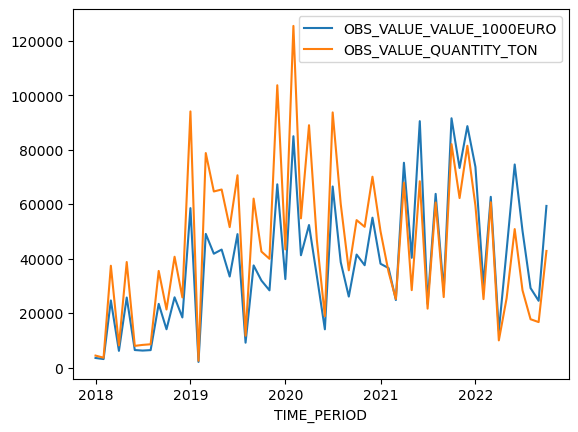

In [403]:
trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter)&
                (trade_data_total['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_VALUE_1000EURO', 'OBS_VALUE_QUANTITY_TON']]\
.set_index('TIME_PERIOD').plot()

<AxesSubplot: xlabel='TIME_PERIOD'>

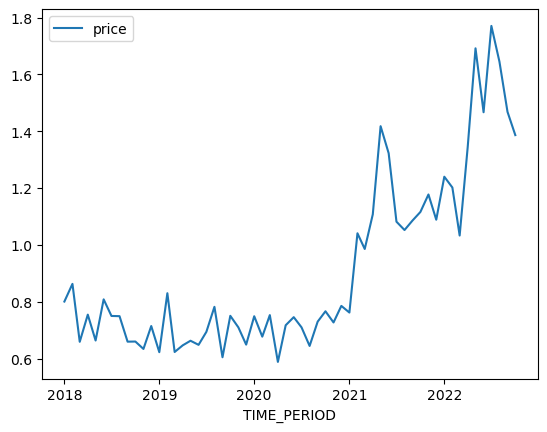

In [404]:
trade_data_total[(trade_data_total['TIME_PERIOD']>=date_filter)&
                (trade_data_total['product']==product_filter)]\
[['TIME_PERIOD', 'price']]\
.set_index('TIME_PERIOD').plot()

# Trade data

#### Graphs of specific Countries:

<AxesSubplot: xlabel='TIME_PERIOD'>

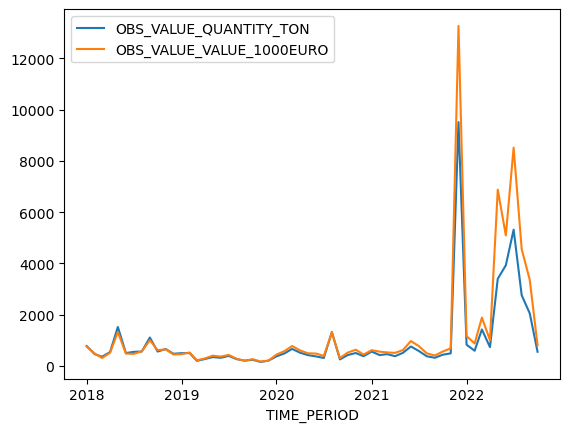

In [405]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Germany')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot()



<AxesSubplot: xlabel='TIME_PERIOD'>

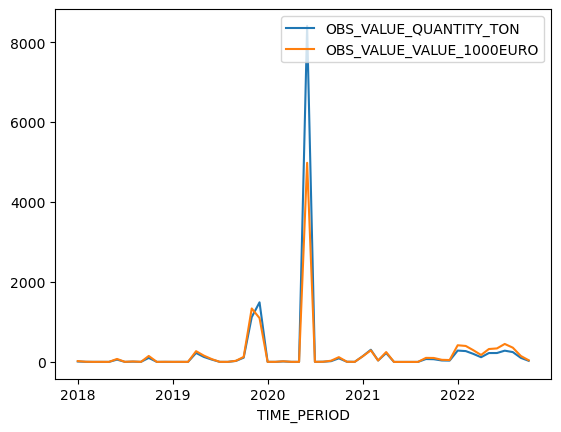

In [406]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Belgium')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot()


<AxesSubplot: xlabel='TIME_PERIOD'>

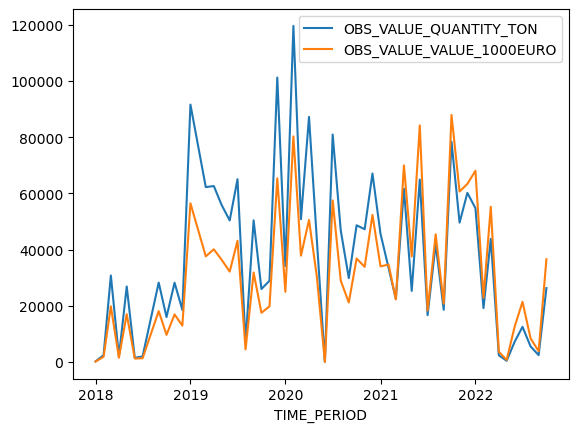

In [407]:
trade_data_pivot[(trade_data_pivot['PARTNER_Labels']=='Ukraine')&
                 (trade_data_pivot['TIME_PERIOD']>=date_filter)&
                (trade_data_pivot['product']==product_filter)]\
[['TIME_PERIOD', 'OBS_VALUE_QUANTITY_TON', 'OBS_VALUE_VALUE_1000EURO']]\
.set_index('TIME_PERIOD').plot()
